# Problem 19: Application of a Groundwater Flow Model to a Water Supply Problem

# INTRODUCTION
_Groundwater flow models are often used in term productivity of local or regional aquifers.
water resource evaluations to assess the longThis exercise presents an example of an application to a local system and involves calibration to an aquifer test and prediction using best estimates of aquifer properties. Of historical interest, this problem is adapted from one of the first applications of a digital model to a water resource problem (Pinder and Bredehoeft, 1968). The specific objective of their study was to assess whether a glaciofluviaI aquifer could provide an adequate water supply for a village in Nova Scotia._


# PROBLEM STATEMENT AND DATA
_The aquifer is located adjacent to the Musquodoboit River, l/4-mile northwest of the village of Musquodoboit Harbour, as shown in Figure 19.1. The aquifer is a glaciofluvial deposit consisting of coarse sand, gravel, cobbles, and boulders deposited in a typical Ushaped glacial valley cut into the slates and quartzites of the Meguma group and the granite intrusive of Devonian age. The contrast in permeability between the granitic and metamorphic rocks and the glaciofluvial valley fill is so great (approximately 106) that the bedrock is considered as impermeable in the aquifer analysis. The aquifer, which is up to 62 feet thick, is extensively overlain by recent alluvial deposits of sand, silt and clay. The alluvial deposits are less permeable and act as confining beds. A cross-section through the valley is given in Figure 19.2._

_A pumping test was conducted to evaluate the aquifer transmissivity and storage coefficient, and to estimate recharge from the river. The test was run for 36 hours using a well discharging at 0.963 cubic feet per second (432 gallons per minute) and three observation wells (see inset of Figure 19.1 for locations). The test was discontinued when the water level in the pumping well became stable. Initial estimates of aquifer parameters were calculated using the Theis curve and the early segment of the drawdown curves for the observation wells. The results were somewhat variable, ranging from 1.15 ft2/s to 1.45 ft2/s. A quasi-steady state formula for estimating transmissivity yielded results on the order of 0.3 ft2/s. Because of the close proximity of boundaries, the pumping test results are difficult to analyze using usual analytical methods._

_A listing of the data set for the MODFLOW model is provided on page 19-4. The aquifer is treated as confined, with transmissivity zones to account for thickness and facies changes. The ratio between zones of transmissivity (1,2, and 4) are given in the data set; absolute values of transmissivity are not given. A map of the transmissivity zones and model boundaries is given in Figure 19.3._

_A uniform value of storage coefficient is used in the analysis. The model is used to simulate drawdown, hence an initial head condition of 0.0 ft is used. Recharge is not specified because only drawdown is simulated. A river is simulated using the RIVER package. Its location is shown in Figure 19.4. Other pertinent data is given in Table 19.1._


## Part a) 
_Run the model with the data set provided. Plot the drawdowns at the observation wells and compare to the field data shown in Table 19.2 and Figure 19.5. Estimate better values of transmissivity and storage coefficient. Do not change location of transmissivity zones. Compare results and continue to adjust T and S until you are satisfied with the results._

In [1]:
#Import and modules/packages that we need to work with
%matplotlib inline
import os
import sys
import platform
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import flopy

In [2]:
#Store the values of each parameter into separate variables
inh = 0.0 #initial head
hk = .3*86400 #hydraulic conductivity ft^2/day
ss = 0.06 #storage coefficient
delr = 100 #grid spacing (uniform)
delc = delr
pr = -.963/7.48*86400 #pumping rate ft^3/day
perlen = 1.5 #stress period length in days
nstp = 10 #number of time steps
tsmult = 1.414 #time step multiplier
it_par = 5 # iteration parameters
mxiter = 50 #maximum number of iterations
accel_par = 1.0 #acceleration parameter
hclose = 0.001 #closure criterion (the head change criterion for convergence)
top = 0
botm = -1
nper = 1
laytyp = 0
ipakcb = 50

#grid 44 rows, 55 cols, 1 layer
nlay = 1 #number of layers
nrow = 44 #number of rows
ncol = 55 #number of columns

#riv package
rstage = 0.0 #river stage
rcond = 1728 #river conductance in ft^2/day
rbot = -10 #river bottom

#print to double check the math is done correctly
print(hk)
print(pr)

25920.0
-11123.422459893047


In [3]:
#Flopy objects
modelname = 'p19' #short for problem 19
exe_name = '../MF2005.1_12/bin/mf2005.exe'
model_ws = 'temp'
mf = flopy.modflow.Modflow(modelname, exe_name=exe_name, model_ws = model_ws)

#call in the discretization package
dis = flopy.modflow.ModflowDis(mf, nlay, nrow, ncol, delr=delr, delc=delc,
                               top=top, botm=botm, nper=nper, perlen=perlen, 
                               nstp=nstp, tsmult=tsmult, steady=False)

#call in the basic package
ibound = np.ones((nlay, nrow, ncol))
strt = 0.0
bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)

True
****Warning -- two packages of the same type:  <class 'flopy.modflow.mflpf.ModflowLpf'> <class 'flopy.modflow.mflpf.ModflowLpf'>
replacing existing Package...


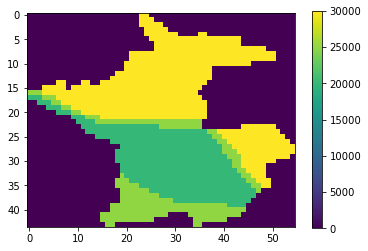

In [341]:
#call in the layer-propery flow (LPF)

fname='..\Data\p19_trans.txt'
print(os.path.isfile(fname))
with open(fname) as f:
    data = f.read().splitlines()
    
f.close()
#print(data)

ibound = []
for s in data:
    for value in s.strip().split(' '):
        ibound.append(int(value))
ibound = np.array(ibound)
ibound = ibound.reshape((44, 55))
plt.imshow(ibound)
hk = np.empty((44, 55), dtype=np.float)
hk[:, :] = ibound[:, :]

hk1 = 30000.
hk2 = 25000.
hk4 = 20000.

hk = np.where(hk==1, hk1, hk)
hk = np.where(hk==2, hk2, hk)
hk = np.where(hk==4, hk4, hk)
plt.imshow(hk)
plt.colorbar()

lpf = flopy.modflow.ModflowLpf(mf, hk=hk, ss=ss, laytyp=laytyp, ipakcb=ipakcb)

In [342]:
#call in the well package (WEL)
# Remember to use zero-based layer, row, column indices!
wel_sp1 = [[0, 27, 31, pr], [0, 27, 31, pr], [0, 28, 34, pr], [0, 30, 31, pr]]
wel_spd = {0: wel_sp1}
wel = flopy.modflow.ModflowWel(mf, stress_period_data=wel_spd)

#call in the preconditioned conjugate-gradient package (PCG) 
pcg = flopy.modflow.ModflowPcg(mf, mxiter=mxiter, hclose=hclose)

#call in the output control package (OC)
oc = flopy.modflow.ModflowOc(mf, stress_period_data={(0, 0): ['save head', 'print budget', 'save budget']})

#call in the river package (RIV)
#figure out how to change conductance from the package
riv_boundary = pd.read_csv('../Data/problem19_riv.csv')
riv_boundary.rcond = 1728
riv_boundary.layer -=1
riv_boundary.row -=1
riv_boundary.col -=1
print(riv_boundary.values)

riv_spd = {0: riv_boundary.values}

riv = flopy.modflow.ModflowRiv(mf, stress_period_data=riv_spd, ipakcb=ipakcb)

****Warning -- two packages of the same type:  <class 'flopy.modflow.mfwel.ModflowWel'> <class 'flopy.modflow.mfwel.ModflowWel'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfpcg.ModflowPcg'> <class 'flopy.modflow.mfpcg.ModflowPcg'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfoc.ModflowOc'> <class 'flopy.modflow.mfoc.ModflowOc'>
replacing existing Package...
[[   0   17    0    0 1728  -10]
 [   0   17    1    0 1728  -10]
 [   0   18    2    0 1728  -10]
 [   0   18    3    0 1728  -10]
 [   0   19    4    0 1728  -10]
 [   0   19    5    0 1728  -10]
 [   0   19    6    0 1728  -10]
 [   0   20    7    0 1728  -10]
 [   0   20    8    0 1728  -10]
 [   0   21    9    0 1728  -10]
 [   0   21   10    0 1728  -10]
 [   0   21   11    0 1728  -10]
 [   0   22   12    0 1728  -10]
 [   0   22   13    0 1728  -10]
 [   0   23   14    0 1728  -10]
 [   0   23   15    0 1728  -10]

In [343]:
# Write the MODFLOW model input files
mf.write_input()

In [344]:
# Run the MODFLOW model
success, buff = mf.run_model()

FloPy is using the following executable to run the model: ../MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: p19.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2017/07/25 12:32:55

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     8    Ground

In [345]:
import flopy.utils.binaryfile as bf

# Create the headfile object
fname = os.path.join(model_ws, 'p19.hds') #"os.path.join" joins together the modelname and the .hds file and stores it in fname
headobj = bf.HeadFile(fname) #create headobj and put values from fname (aka 'p1_pa.hds') inside it
times = headobj.get_times() #assign the headobj values to the variable "times"
print(times) #prints the time at each stress period

#print hydraulic head (Table 14.2)
idx = (0, 28, 31) #(nlay, nrow, ncol) *remember you have to subtract 1 from the original numbers for python - (1, 10, 12)*
ts = headobj.get_ts([idx])
print(ts)

[0.020063508, 0.048433311, 0.088548213, 0.14527068, 0.22547624, 0.33888692, 0.49924961, 0.72600245, 1.046631, 1.4999998]
[[ 0.02006351 -0.06299805]
 [ 0.04843331 -0.13870685]
 [ 0.08854821 -0.21216395]
 [ 0.14527068 -0.28089201]
 [ 0.22547624 -0.34508279]
 [ 0.33888692 -0.40513939]
 [ 0.49924961 -0.46141082]
 [ 0.72600245 -0.51427734]
 [ 1.04663098 -0.56430143]
 [ 1.49999976 -0.61247969]]


(0, 0.61247969)

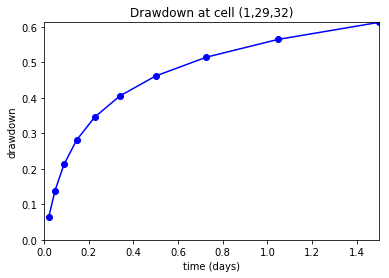

In [346]:
# Plot the drawdown versus time
plt.subplot(1, 1, 1)
ttl = 'Drawdown at cell ({0},{1},{2})'.format(idx[0] + 1, idx[1] + 1, idx[2] + 1) #we are adding 1 to each part of idx to that it prints out the real values and not the code values
plt.title(ttl) #prints/plots title
plt.xlabel('time (days)') #labels the x-axis
plt.ylabel('drawdown') #labels the y-axis
#here we do "0-ts..." in order to show the drawdown of 
plt.plot(ts[:, 0], 0-ts[:, 1], 'bo-') #(x, y, color/type of line)
plt.xlim(0, ts[:, 0].max())
plt.ylim(0, (0-ts[:, 1]).max())

(-0.61247969, -0.062998049)

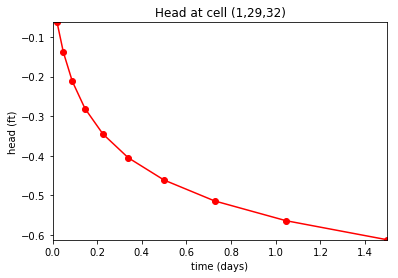

In [347]:
# Plot the head versus time
plt.subplot(1, 1, 1)
ttl = 'Head at cell ({0},{1},{2})'.format(idx[0] + 1, idx[1] + 1, idx[2] + 1)
plt.title(ttl)
plt.xlabel('time (days)')
plt.ylabel('head (ft)')
plt.plot(ts[:, 0], ts[:, 1], 'ro-')
plt.xlim(0, ts[:, 0].max())
plt.ylim(ts[:, 1].min(), ts[:, 1].max())

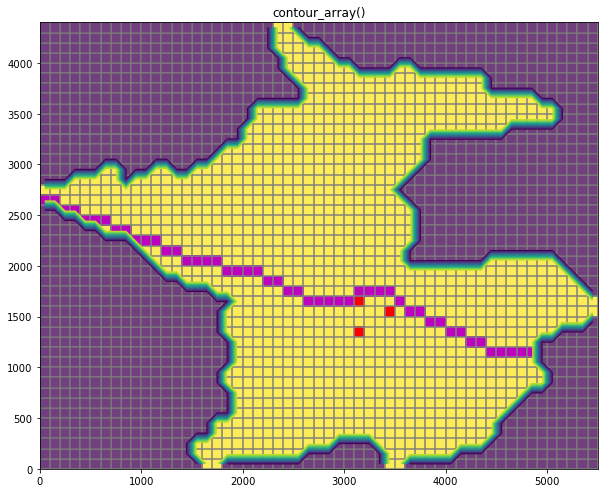

In [348]:
fname = os.path.join(modelname, 'p19.cbc')
head = headobj.get_data(totim=times[-1])
levels = np.linspace(head.min(), head.max(), 10)

fig = plt.figure(figsize=(10, 10))

#plot_array
ax = fig.add_subplot(1, 1, 1, aspect='equal')
ax.set_title('contour_array()')
modelmap = flopy.plot.ModelMap(model=mf)
quadmesh = modelmap.plot_ibound()
quadmesh = modelmap.plot_array(head, masked_values=[999.], alpha=0.5)
modelmap.plot_bc("WEL")
modelmap.plot_bc("RIV", color='m')
linecollection = modelmap.plot_grid()
contour_set = modelmap.contour_array(head, masked_values=[999.], levels=levels)



In [349]:
#create different variables for each well so that you can plot them
table2 = pd.read_csv('../Data/table19.2.csv')
print(table2)

well1=table2.ix[0:, ['Time (min)', 'Observation Well 1']]
print(well1)

well2=table2.ix[0:, ['Time (min)', 'Observation Well 2']]
print(well2)

well3=table2.ix[0:, ['Time (min)', 'Observation Well 3']]
print(well3)

   Time (min)  Observation Well 1  Observation Well 2  Observation Well 3
0           1                0.17                0.04                0.00
1           4                0.26                0.12                0.01
2          10                0.33                0.16                0.02
3          40                0.48                0.22                0.08
4         100                0.57                0.29                0.14
5         400                0.79                0.51                0.30
6        1000                0.99                0.70                0.50
7        2000                1.19                0.86                0.68
8        3000                1.33                0.98                0.78
   Time (min)  Observation Well 1
0           1                0.17
1           4                0.26
2          10                0.33
3          40                0.48
4         100                0.57
5         400                0.79
6        1000         

## Measured Data: Original Data

In [350]:
# *remember you have to subtract 1 from the original numbers for python*
#well 1 (28, 32)
idx1 = (0, 27, 31) #(nlay, nrow, ncol)

#well 2 (29, 35)
idx2 = (0, 28, 34)

#well 3 (31, 32)
idx3 = (0, 30, 31)

ts = headobj.get_ts([idx1, idx2, idx3])
print(ts)
#prints out time, and the rate of drawdown at well 1, well 2, and well 3

[[ 0.02006351 -0.24465685 -0.1240171  -0.12516536]
 [ 0.04843331 -0.37030181 -0.19301292 -0.19633463]
 [ 0.08854821 -0.45261303 -0.24637137 -0.25230476]
 [ 0.14527068 -0.51977122 -0.29767942 -0.30635354]
 [ 0.22547624 -0.5804643  -0.34966934 -0.36111379]
 [ 0.33888692 -0.63706672 -0.40188131 -0.41602725]
 [ 0.49924961 -0.69029856 -0.45342359 -0.47008908]
 [ 0.72600245 -0.74055547 -0.50364125 -0.52263778]
 [ 1.04663098 -0.788297   -0.55228293 -0.57362956]
 [ 1.49999976 -0.83432484 -0.59975934 -0.62386435]]


## Model Data: Edited Data

In [351]:
#these are the original values, print them out to see what they are before we change them
well_data=np.array(table2)
print(well_data)

[[  1.00000000e+00   1.70000000e-01   4.00000000e-02   0.00000000e+00]
 [  4.00000000e+00   2.60000000e-01   1.20000000e-01   1.00000000e-02]
 [  1.00000000e+01   3.30000000e-01   1.60000000e-01   2.00000000e-02]
 [  4.00000000e+01   4.80000000e-01   2.20000000e-01   8.00000000e-02]
 [  1.00000000e+02   5.70000000e-01   2.90000000e-01   1.40000000e-01]
 [  4.00000000e+02   7.90000000e-01   5.10000000e-01   3.00000000e-01]
 [  1.00000000e+03   9.90000000e-01   7.00000000e-01   5.00000000e-01]
 [  2.00000000e+03   1.19000000e+00   8.60000000e-01   6.80000000e-01]
 [  3.00000000e+03   1.33000000e+00   9.80000000e-01   7.80000000e-01]]


In [352]:
#here we are making a copy of the original list and then dividing the first column 
#by 1440 to change minutes to days. Then print to see new values
well_data2=well_data.copy()
well_data2[:, 0]=well_data2[:, 0]/1440
print(well_data2)

[[  6.94444444e-04   1.70000000e-01   4.00000000e-02   0.00000000e+00]
 [  2.77777778e-03   2.60000000e-01   1.20000000e-01   1.00000000e-02]
 [  6.94444444e-03   3.30000000e-01   1.60000000e-01   2.00000000e-02]
 [  2.77777778e-02   4.80000000e-01   2.20000000e-01   8.00000000e-02]
 [  6.94444444e-02   5.70000000e-01   2.90000000e-01   1.40000000e-01]
 [  2.77777778e-01   7.90000000e-01   5.10000000e-01   3.00000000e-01]
 [  6.94444444e-01   9.90000000e-01   7.00000000e-01   5.00000000e-01]
 [  1.38888889e+00   1.19000000e+00   8.60000000e-01   6.80000000e-01]
 [  2.08333333e+00   1.33000000e+00   9.80000000e-01   7.80000000e-01]]


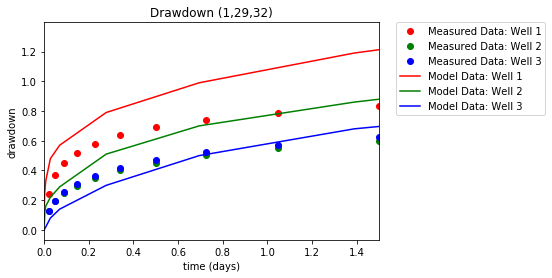

In [353]:
# Plot the drawdown versus time
plt.subplot(1, 1, 1)
ttl = 'Drawdown ({0},{1},{2})'.format(idx[0] + 1, idx[1] + 1, idx[2] + 1) #we are adding 1 to each part of idx to that it prints out the real values and not the code values
plt.title(ttl) #prints/plots title
plt.xlabel('time (days)') #labels the x-axis
plt.ylabel('drawdown') #labels the y-axis
#here we do "0-ts..." in order to show the drawdown of 

plt.plot(ts[:, 0], 0-ts[:, 1], 'ro', label='Measured Data: Well 1') #well 1 measured data
plt.plot(ts[:, 0], 0-ts[:, 2], 'go', label='Measured Data: Well 2') #well 2 measured data
plt.plot(ts[:, 0], 0-ts[:, 3], 'bo', label='Measured Data: Well 3') #well 3 measured data
plt.plot(well_data2[:, 0], well_data2[:, 1], 'r-', label='Model Data: Well 1') #well 1 model data
plt.plot(well_data2[:, 0], well_data2[:, 2], 'g-', label='Model Data: Well 2') #well 2 model data
plt.plot(well_data2[:, 0], well_data2[:, 3], 'b-', label='Model Data: Well 3') #well 3 model data
plt.xlim(0, ts[:, 0].max())
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) #puts the legend to the right of the plot
#plt.ylim(0, (0-ts[:, 1:]).max())



<a list of 0 text.Text objects>

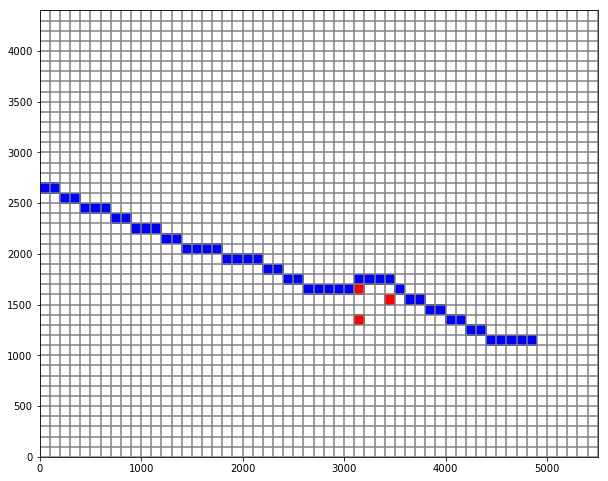

In [327]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
modelmap = flopy.plot.ModelMap(model=mf)
quadmesh = modelmap.plot_ibound()
linecollection = modelmap.plot_grid()
riv = modelmap.plot_bc('RIV', color='b', plotAll=True)
quadmesh = modelmap.plot_bc('WEL', kper=1, plotAll=True)
contour_set = modelmap.contour_array(head, levels=np.arange(0, 36, 1), colors='g')
plt.clabel(contour_set, inline=1, fontsize=14)

In [218]:
fname = os.path.join(model_ws, 'p19.cbc')
cbb = flopy.utils.CellBudgetFile(fname)
frf = cbb.get_data(text='FLOW RIGHT FACE')
fff = cbb.get_data(text='FLOW FRONT FACE')

rflow = cbb.get_data(text='RIVER LEAKAGE') #create an array/for loop to get out first value of every step
#cbb.list_records()

#create new list
rlist=[]

#create for loop to store only the first value of each time step from riv_flow into riv_list
for riv in rflow:
    rlist.append(riv['q'][0])
    
print(rlist)

Exception: The specified text string is not in the budget file.